The discrete convolution:
$$
\partial_t^\alpha (t_n) = \frac{1}{\tau^\alpha} \sum_{j=1}^{n+1} \omega_j^\alpha \Big[u(t_{n-j+1}) - u(0)  \Big]
$$
with 
<!-- $$ -->
<!-- \omega_0^\alpha = 1; \quad \omega_j^\alpha = - \frac{\alpha -j + 1}{j}, \quad j=1,\ldots . -->
<!-- $$ -->

$$
\omega_1^\alpha = 1; \quad \omega_j^\alpha = \frac{j-α-2}{j-1} ω_{j-1}^α, \quad j=2,\ldots .
$$

The following scheme is implemented:

$$
 \displaystyle \left(\frac{1}{τ^α} ω_1 M + A\right)u^n = f^n + \frac{1}{τ^α} \sum_{j=1}^{n} ω_j M u^1 - \frac{1}{τ^α} \sum_{j=2}^{n} ω_{n-j+1} M u^{j}
$$

In [13]:
module FractionalEM
  using GradientRobustMultiPhysics
  using ExtendableGrids
  using GridVisualize
  using ExtendableSparse
  using SpecialFunctions

  """
    ReactionConvectionDiffusionOperator(α, β, ϵ)

    TBW
  """
  function ReactionConvectionDiffusionOperator(γ, β, ϵ)
    function action_kernel!(result, input, x, t)
        β.x = x
        β.time = t
        eval_data!( γ )
        eval_data!( β )
        # α * u_h + β_1 * ∇_xu_h + β_2 ∇_y u_h
        result[1] = γ.val[1] * input[1] + β.val[1] * input[2] + β.val[2] * input[3]
        # Laplacian
        result[2] = ϵ * input[2]
        result[3] = ϵ * input[3]
        return nothing
    end
    action = Action(action_kernel!, [3, 3], dependencies = "XT", bonus_quadorder = max(γ.bonus_quadorder, β.bonus_quadorder))
    return BilinearForm([OperatorPair{Identity, Gradient}, OperatorPair{Identity, Gradient}], action;
    name=" ϵ(∇ u, ∇ v) + (γ u + β⋅∇u, v)", transposed_assembly = true)
  end

  """
    get_problem_data(ν)

  TBW
  """
  function get_problem_data(ϵ, p=1.0, α=1.0)
    γ = DataFunction([1.0]; name = "γ")
    β = DataFunction([1.0,2.0]; name = "β")    
    function exact!(result, x, t)
        result[1] = x[1]*t^p
     end
    
    u = DataFunction(exact!, [1,2]; name="u", dependencies="XT", bonus_quadorder=5)
    dt_u = eval_dt(u)
    ∇u = eval_∇(u)
    Δu = eval_Δ(u)
    function rhs!(result, x, t)    
        dt_u = x[1] * gamma(p+1)/gamma(p-α+1)*t^(p-α)
        result[1] = dt_u-ϵ*Δu(x,t)[1] + dot(β(), ∇u(x,t))[1] + dot(γ(), u(x,t)[1]) # γ * u(x,t)[1]
      return nothing
    end
    f = DataFunction(rhs!, [1,2]; name = "f", dependencies = "XT", bonus_quadorder = 5)
    return γ, β, u, ∇(u), f
  end 
  
  function main(; ϵ=1.0, nrefinements=2, nsteps=10, Tf=1.0, α=1, tpower=1.0, verbosity=0)
    ω = zeros(nsteps+1)
    ω[1] = 1.0
    ω[2] = -α
    for j=3:nsteps+1
        ω[j] = (j-2-α)/(j-1)*ω[j-1]
    end
    # @show ω
    # computing the sum of ω
    sum_omega = zeros(nsteps+1)
    sum_omega[1] = ω[1]
    for j=2:nsteps+1
        sum_omega[j] = sum_omega[j-1] + ω[j]
    end
    # @show  sum_omega;

    ## finite elements and bilinear forms
    # Prepare the matrices and rhs coming from space discretization 
    ## set log level
    set_verbosity(verbosity)    
    ## negotiate data functions to the package
    γ, β, u, ∇u, f = get_problem_data(ϵ, tpower, α)
    # choose a finite element type
    FEType = H1Pk{1,2,2}
    xgrid = uniform_refine(grid_unitsquare(Triangle2D), nrefinements)
    FES = FESpace{FEType}(xgrid)
    Solution = FEVector(FES)
    n_dofs = FES.ndofs
    interpolate!(Solution[1], u; time = 0.0)    

    M = FEMatrix(FES)
    assemble_operator!(M[1,1], BilinearForm([Identity, Identity]))
    # @show M.entries
    # println(size(M[1,1]))
    @show FES.ndofs
    A = FEMatrix(FES)
    assemble_operator!(A[1,1], ReactionConvectionDiffusionOperator(γ, β, ϵ); time=0.0)
    # @show A.entries

    rhs = FEVector(FES)
    assemble_operator!(rhs[1], LinearForm(Identity, f); time=0.0)
    # @show rhs.entries

    dt = Array{BoundaryData,1}(undef,0)
    push!(dt, BoundaryData(BestapproxDirichletBoundary; regions = [1,2,3,4], data = u))
    dofs = boundarydata!(Solution[1], dt; time = 0.0)
    
    t0 = 0.0
    tau = (Tf - t0)/nsteps
    @show nrefinements, nsteps

    V1 = zeros(Float64, FES.ndofs, 1)
    Mu0 = zeros(Float64, FES.ndofs)
    temp = zeros(Float64, FES.ndofs, nsteps)    
    temp[:, 1] = Solution[1].entries

    SystemMatrix = FEMatrix(FES)
    # @show SystemMatrix
    SystemRHS = FEVector(FES)
    SystemSol = FEVector(FES)

    # SolVector = Array{FEVector{Float64}}([])
    Sols = Array{FEVector}(undef, nsteps)
    # push!(SolVector, Solution)

    scale = tau^α
    l2 = zero(Float64); h1=zeros(Float64)
    oldL2 = zero(Float64); oldh1 = zero(Float64)
    eL2 = zero(Float64); eh1 = zero(Float64)

    for m=2:nsteps
      t0 = t0+tau
      fill!(SystemRHS.entries, 0)
      fill!(rhs.entries, 0)
      assemble_operator!(rhs[1], LinearForm(Identity, f), time= t0 )
      V1[:, 1] = rhs.entries
      addblock!(SystemRHS[1], V1[:,1]; factor= 1.0 )
      @show ω[m-1]
      addblock!(SystemRHS[1], Mu0; factor= sum_omega[m]/scale)
      for j=2:m-1
        # println(m," ", j, " ", m-j+1, " ", bj[m-j+1])
        addblock!(SystemRHS[1], M.entries*temp[:,j]; factor= -ω[m-j+1]/scale)
      end

      fill!(SystemMatrix.entries.cscmatrix.nzval, 0)
      fill!(A.entries.cscmatrix.nzval, 0)
      # assembling the matrices with coefficients depending on time     
      assemble_operator!(A[1, 1], ReactionConvectionDiffusionOperator(γ, β, ϵ); time=t0 )
      addblock!(SystemMatrix[1, 1], M[1, 1]; factor= 1.0/scale)
      addblock!(SystemMatrix[1, 1], A[1, 1]; factor= 1.0)

      flush!(SystemMatrix.entries)      
      #@show SystemRHS.entries
      dofs = boundarydata!(SystemSol[1], dt; time = t0)        
      for dof in dofs
        SystemRHS[1][dof] = 1e60 * SystemSol[1][dof]
        SystemMatrix[1,1][dof,dof] = 1e60
      end
      SystemSol.entries[:] = SystemMatrix.entries \ SystemRHS.entries
      for j = 1 : n_dofs 
        Solution[1][j] = SystemSol[1][j]
      end
      # push!(SolVector, Solution)
      temp[:, m] = Solution[1].entries

      L2Error_u = L2ErrorIntegrator(u, Identity; time= t0)
      l2 = evaluate(L2Error_u, Solution[1])
      eL2 += (l2 + oldL2) * tau * 0.5
      oldL2 = l2

      h1erro = L2ErrorIntegrator(∇(u), Gradient; time= t0)
      h1 = evaluate(h1erro, Solution[1])
      eh1 += (l2 + oldh1) * tau * 0.5
      oldh1 = h1

      @show (sqrt(eL2), sqrt(eh1))
    end #endfor time 
    #@show (sqrt(eL2))
    (sqrt(l2), sqrt(h1))
  end #end main 
end #module 

Main.FractionalEM

In [20]:
ns = [10 20 40 80 160]
eL2=[]; eH1=[];
for n in ns
    el2, eh1 = Main.FractionalEM.main(nsteps=n, α=0.5, tpower=2)
    push!(eL2, el2)
    push!(eH1, eh1)
end

FES.ndofs = 145
(nrefinements, nsteps) = (2, 10)
ω[m - 1] = 1.0
(sqrt(eL2), sqrt(eh1)) = (0.0002996792097453012, 0.0002996792097453012)
ω[m - 1] = -1.0
(sqrt(eL2), sqrt(eh1)) = (0.0005758504755721849, 0.0015787984017256727)
ω[m - 1] = -0.0
(sqrt(eL2), sqrt(eh1)) = (0.0008112288248545735, 0.0025120279817221892)
ω[m - 1] = -0.0
(sqrt(eL2), sqrt(eh1)) = (0.0010071807682499225, 0.0032591264327224527)
ω[m - 1] = -0.0
(sqrt(eL2), sqrt(eh1)) = (0.0011748910458217244, 0.0038848676563301722)
ω[m - 1] = -0.0
(sqrt(eL2), sqrt(eh1)) = (0.0013226353110890646, 0.004428587819984844)
ω[m - 1] = -0.0
(sqrt(eL2), sqrt(eh1)) = (0.0014557855764990766, 0.004914081028252734)
ω[m - 1] = -0.0
(sqrt(eL2), sqrt(eh1)) = (0.0015778329848724214, 0.005356199346140435)
ω[m - 1] = -0.0
(sqrt(eL2), sqrt(eh1)) = (0.001691122496583283, 0.005764639983005414)
FES.ndofs = 145
(nrefinements, nsteps) = (2, 20)
ω[m - 1] = 1.0
(sqrt(eL2), sqrt(eh1)) = (8.168290543294445e-5, 8.168290543294445e-5)
ω[m - 1] = -1.0
(sqrt(eL2), sqr

ω[m - 1] = -0.0
(sqrt(eL2), sqrt(eh1)) = (0.00013710988184987956, 0.0004793690393226081)
ω[m - 1] = -0.0
(sqrt(eL2), sqrt(eh1)) = (0.00013972115083972592, 0.0004885295584564448)
ω[m - 1] = -0.0
(sqrt(eL2), sqrt(eh1)) = (0.00014228489832059817, 0.0004975228241139231)
ω[m - 1] = -0.0
(sqrt(eL2), sqrt(eh1)) = (0.00014480356504092032, 0.0005063574547735345)
ω[m - 1] = -0.0
(sqrt(eL2), sqrt(eh1)) = (0.0001472793995275492, 0.0005150413876736593)
ω[m - 1] = -0.0
(sqrt(eL2), sqrt(eh1)) = (0.00014971447712571476, 0.0005235819466164279)
ω[m - 1] = -0.0
(sqrt(eL2), sqrt(eh1)) = (0.00015211071691474735, 0.0005319859021497103)
ω[m - 1] = -0.0
(sqrt(eL2), sqrt(eh1)) = (0.00015446989674429833, 0.0005402595250178021)
ω[m - 1] = -0.0
(sqrt(eL2), sqrt(eh1)) = (0.0001567936666099086, 0.0005484086336739889)
ω[m - 1] = -0.0
(sqrt(eL2), sqrt(eh1)) = (0.00015908356056258303, 0.0005564386365581171)
ω[m - 1] = -0.0
(sqrt(eL2), sqrt(eh1)) = (0.00016134100732478679, 0.0005643545697602161)
ω[m - 1] = -0.0
(sqrt(e

ω[m - 1] = -0.0
(sqrt(eL2), sqrt(eh1)) = (5.838468223966761e-5, 0.00020521154299569906)
ω[m - 1] = -0.0
(sqrt(eL2), sqrt(eh1)) = (5.9151512813303415e-5, 0.00020788801652855385)
ω[m - 1] = -0.0
(sqrt(eL2), sqrt(eh1)) = (5.990882568325388e-5, 0.00021053145774796043)
ω[m - 1] = -0.0
(sqrt(eL2), sqrt(eh1)) = (6.065694194795788e-5, 0.00021314297755554342)
ω[m - 1] = -0.0
(sqrt(eL2), sqrt(eh1)) = (6.139616703956525e-5, 0.0002157236326213096)
ω[m - 1] = -0.0
(sqrt(eL2), sqrt(eh1)) = (6.212679161130261e-5, 0.00021827442847705146)
ω[m - 1] = -0.0
(sqrt(eL2), sqrt(eh1)) = (6.28490923755698e-5, 0.00022079632243383467)
ω[m - 1] = -0.0
(sqrt(eL2), sqrt(eh1)) = (6.356333289454586e-5, 0.00022329022633075564)
ω[m - 1] = -0.0
(sqrt(eL2), sqrt(eh1)) = (6.426976432523883e-5, 0.00022575700912251065)
ω[m - 1] = -0.0
(sqrt(eL2), sqrt(eh1)) = (6.496862612100955e-5, 0.0002281974993134911)
ω[m - 1] = -0.0
(sqrt(eL2), sqrt(eh1)) = (6.566014669164964e-5, 0.00023061248724617195)
ω[m - 1] = -0.0
(sqrt(eL2), sqrt(e

(sqrt(eL2), sqrt(eh1)) = (0.00011035195799831958, 0.0003868674007634543)
ω[m - 1] = -0.0
(sqrt(eL2), sqrt(eh1)) = (0.00011076091190755662, 0.000388298198592399)
ω[m - 1] = -0.0
(sqrt(eL2), sqrt(eh1)) = (0.00011116836141302905, 0.00038972374355214913)
ω[m - 1] = -0.0
(sqrt(eL2), sqrt(eh1)) = (0.00011157432299610737, 0.000391144093075529)
ω[m - 1] = -0.0
(sqrt(eL2), sqrt(eh1)) = (0.0001119788128394154, 0.00039255930355637584)
ω[m - 1] = -0.0
(sqrt(eL2), sqrt(eh1)) = (0.00011238184683435669, 0.0003939694303756578)
ω[m - 1] = -0.0
(sqrt(eL2), sqrt(eh1)) = (0.00011278344058839772, 0.00039537452792676306)
ω[m - 1] = -0.0
(sqrt(eL2), sqrt(eh1)) = (0.00011318360943211982, 0.0003967746496399752)
ω[m - 1] = -0.0
(sqrt(eL2), sqrt(eh1)) = (0.00011358236842604755, 0.000398169848006177)
ω[m - 1] = -0.0
(sqrt(eL2), sqrt(eh1)) = (0.00011397973236726106, 0.0003995601745998167)
ω[m - 1] = -0.0
(sqrt(eL2), sqrt(eh1)) = (0.0001143757157958028, 0.0004009456801011459)
ω[m - 1] = -0.0
(sqrt(eL2), sqrt(eh1)) 

L2: Any[0.0019244753478083847, 0.0009622631607217074, 0.0004811319109533652, 0.00024056596312530665, 0.00012028298194909553]
H1: Any[0.009335407411439529, 0.004667814890052451, 0.0023339088870347937, 0.0011669544768795087, 0.0005834772401249997]


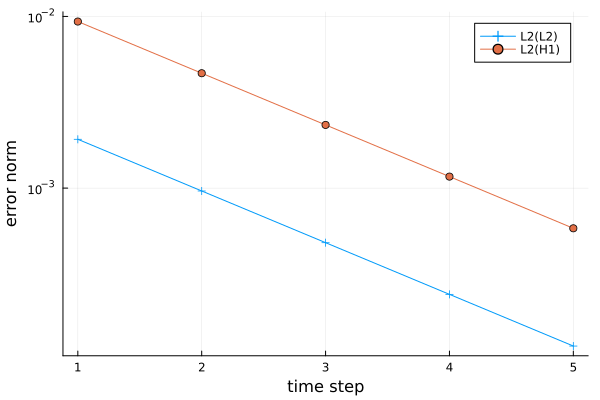

In [21]:
using Plots
println("L2: ", eL2)
println("H1: ", eH1)
taus = [ 1,2,3,4,5]
plot(taus,[eL2 eH1],
    yaxis=:log10,
    label=["L2(L2)" "L2(H1)"],
    shape=:auto,
    xlabel="time step",ylabel="error norm")